In [1]:
%matplotlib notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from IPython.core.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt

import importlib as imp
%cd ../

/media/work/docs/codes/c++/QSVT_framework/simulations


In [2]:
import os
import qiskit
import XW_waves.xw_1d as xw
mix = xw.mix
mse = xw.mse
reload = mix.reload_module
import pylib.circuit_lib as lib
os.getpid()

2643

In [15]:
# -------------------------------------------
# --- Create initial circuit (operator A) ---
# -------------------------------------------
reload(lib)
a_ = qiskit.QuantumRegister(1, "a")

qc = qiskit.QuantumCircuit(a_, name="A")


prob_G = 0.1

coef_v = np.sqrt(prob_G)
angle_rot = 2*np.arccos(coef_v)
print("rotation angle: {:0.3e}".format(angle_rot))
qc.ry(angle_rot, a_)

# set |1> as a good state:
qc.x(a_)

# store the circuit as a gate:
gINIT_ = qc.to_gate()

print(qc.draw(fold = 110))

str_wv, pp, qq = lib.Wavefunction_adv(qc, column=True, systems=[1], width=10)
print(str_wv)
pr_good_, pr_bad_ = lib.analysis_prob(pp, qq)

del qc, coef_v, str_wv, pp, qq

rotation angle: 2.498e+00
   ┌────────────┐┌───┐
a: ┤ Ry(2.4981) ├┤ X ├
   └────────────┘└───┘
        0.949+0.000j |0>   
        0.316+0.000j |1>   

prob. of GS: 1.000e-01
prob. of BS: 9.000e-01
BS + GS: 1.000e+00
optimal number of amplification operators:  2.440997861666967


In [16]:
# -----------------------------------------
# --- Amplitude amplification operator ---
# -----------------------------------------

# Q = - A R_0 A^{-1} R_good;
# |good> = |1>

qc = qiskit.QuantumCircuit(a_, name="U")

# sign change of the good state (state |1>)
qc.z(a_)

# inverse the creation gate:
gAi = gINIT_.inverse()
qc.append(gAi, a_)

# sign change of the zero state: 
qc.x(a_)
qc.z(a_)
qc.x(a_)

# the creation gate again:
qc.append(gINIT_, a_)

print(qc.draw())

gU_ = qc.to_gate()

del qc, gAi

   ┌───┐┌──────┐┌───┐┌───┐┌───┐┌───┐
a: ┤ Z ├┤ A_dg ├┤ X ├┤ Z ├┤ X ├┤ A ├
   └───┘└──────┘└───┘└───┘└───┘└───┘


In [17]:
# -----------------------------------------
# --- Amplitude estimation circuit ---
# -----------------------------------------
reload(lib)

nm = 6

dd = lib.get_phase_estimation(nm, a_, gINIT_, gU_)
print("--- Resulting circuit ---")
if(nm <= 8):
    print(dd["circuit"].draw(fold = 110))

# --- print the resulting data ---
print()
print("desired good prob.: {:0.3e}".format(pr_good_))
print("desired bad prob.: {:0.3e}".format(pr_bad_))

th_aa = dd["phase (max prob)"] / 2.
a_est = np.sin(th_aa)**2

th_aa_next = dd["phase (next prob)"] / 2.
a_est_next = np.sin(th_aa_next)**2
analytical_abs_error = 2*np.pi*np.sqrt(pr_bad_*(1-pr_bad_))/(2**nm) + np.pi**2/(2**(2*nm)) 
analytical_probability = 8./np.pi**2

print("estimated bad probability \t= {:0.3e}    \twith prob. = {:0.3e}".format(
    a_est, dd["max. prob"]
))
print("next estimated bad probability \t= {:0.3e}    \twith prob. = {:0.3e}".format(
    a_est_next, dd["next prob"]
))
print()
print("estimated good probability: {:0.3e}".format(1 - a_est))
print("abs. error of the good prob.: {:0.3e}".format( 
    np.abs(pr_good_ - (1 - a_est))
))
print()
print("max + next probs.: {:0.3e}".format(dd["max + next probs"]))
print("analytical absolute error: {:0.3e}".format(analytical_abs_error))
print("analytical minimum probability of success: {:0.3e}".format(analytical_probability))

--- Resulting circuit ---
      ┌───┐                                      ┌───────┐┌─┐               
 m_0: ┤ H ├──■───────────────────────────────────┤0      ├┤M├───────────────
      ├───┤  │                                   │       │└╥┘┌─┐            
 m_1: ┤ H ├──┼─────■─────────────────────────────┤1      ├─╫─┤M├────────────
      ├───┤  │     │                             │       │ ║ └╥┘┌─┐         
 m_2: ┤ H ├──┼─────┼─────■───────────────────────┤2      ├─╫──╫─┤M├─────────
      ├───┤  │     │     │                       │  F_dg │ ║  ║ └╥┘┌─┐      
 m_3: ┤ H ├──┼─────┼─────┼─────■─────────────────┤3      ├─╫──╫──╫─┤M├──────
      ├───┤  │     │     │     │                 │       │ ║  ║  ║ └╥┘┌─┐   
 m_4: ┤ H ├──┼─────┼─────┼─────┼──────■──────────┤4      ├─╫──╫──╫──╫─┤M├───
      ├───┤  │     │     │     │      │          │       │ ║  ║  ║  ║ └╥┘┌─┐
 m_5: ┤ H ├──┼─────┼─────┼─────┼──────┼──────■───┤5      ├─╫──╫──╫──╫──╫─┤M├
      ├───┤┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌──┴──┐┌──┴──┐└

In [61]:
dd["data"]

{'101101111101': 408,
 '010010000011': 383,
 '101101111100': 62,
 '101110000000': 1,
 '101101111110': 15,
 '010010000100': 62,
 '010010000001': 11,
 '101101111010': 5,
 '010010001001': 1,
 '010001111110': 1,
 '010010000010': 10,
 '101101111111': 12,
 '101101110011': 3,
 '010010001100': 1,
 '010010101100': 1,
 '101110101110': 1,
 '010010000000': 5,
 '010010000101': 6,
 '101101101101': 1,
 '010010001000': 1,
 '101110000100': 1,
 '010010010000': 1,
 '101101111011': 5,
 '110001001101': 1,
 '101101111001': 2,
 '101110000001': 2,
 '101100001101': 1,
 '010010000110': 2,
 '101110001000': 1,
 '010001110010': 1,
 '010000000111': 1,
 '101101110110': 3,
 '101110000010': 1,
 '010010000111': 2,
 '011101111101': 1,
 '101110010001': 1,
 '101101000111': 1,
 '010001111111': 1,
 '010001111100': 1,
 '010010010110': 1,
 '010001110111': 1,
 '010001111010': 1,
 '100011010110': 1,
 '101101110111': 1}

desired good prob.: 1.000e-01


<IPython.core.display.Javascript object>


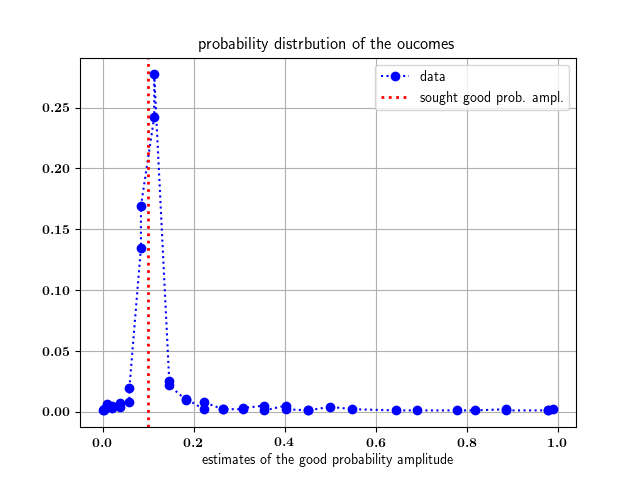

In [21]:
# Plot the histogram (here, just a standard plot with markers)
print("desired good prob.: {:0.3e}".format(pr_good_))

probs_good = 1 - np.sin(dd["phases"]/2.)**2
arg_sort = probs_good.argsort()
probs_good = probs_good[arg_sort]
probs_meas = dd["probs"][arg_sort]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(
    probs_good, 
    probs_meas, 
    color='b', marker="o", linestyle = ':', label = "data"
)
ax.axvline(x=pr_good_, linestyle = ':', color='r', linewidth = 2, label="sought good prob. ampl.")
plt.xlabel("estimates of the good probability amplitude")
plt.title("probability distrbution of the oucomes")
ax.legend()
plt.grid(True)
plt.show()